In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from cars_utils import make_training_dataset
%matplotlib inline

# Try 14-features Logistic Regression

In [5]:
df_dia = pd.read_csv('tests/csvs/r_dia_k - 1 - Final.csv', index_col=0).dropna(subset=['Numero carro'])
df_noche = pd.read_csv('tests/csvs/r_noche_k - Final.csv', index_col=0).dropna(subset=['Numero carro'])

In [6]:
print(df_dia.frame_number.tail())
print(df_noche.frame_number.head())

46150    72052
46151    72053
46152    72054
46153    72055
46154    72056
Name: frame_number, dtype: int64
0     99
1    100
2    102
3    111
4    112
Name: frame_number, dtype: int64


In [7]:
df_noche.frame_number = df_noche.frame_number + 73000

print(df_dia.frame_number.tail())
print(df_noche.frame_number.head())

46150    72052
46151    72053
46152    72054
46153    72055
46154    72056
Name: frame_number, dtype: int64
0    73099
1    73100
2    73102
3    73111
4    73112
Name: frame_number, dtype: int64


In [8]:
print(df_dia['Numero carro'].max(), len(df_dia['Numero carro'].unique()))
print(df_noche['Numero carro'].max(), len(df_noche['Numero carro'].unique()))
print()
print(df_dia['Numero carro'].tail())
print(df_noche['Numero carro'].head())

158.0 158
80.0 80

46150    158.0
46151    158.0
46152    158.0
46153    158.0
46154    158.0
Name: Numero carro, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Numero carro, dtype: float64


In [9]:
df_noche['Numero carro'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80.])

In [10]:
df_noche['Numero carro'] = df_noche['Numero carro'] + 158

print(df_dia['Numero carro'].tail())
print(df_noche['Numero carro'].head())

46150    158.0
46151    158.0
46152    158.0
46153    158.0
46154    158.0
Name: Numero carro, dtype: float64
0    159.0
1    159.0
2    159.0
3    159.0
4    159.0
Name: Numero carro, dtype: float64


In [11]:
df = pd.concat([df_dia, df_noche], ignore_index=True)

print(df_dia.info())
print(df_noche.info())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36899 entries, 0 to 46154
Data columns (total 13 columns):
frame_number        36899 non-null int64
vehicle_type        36899 non-null object
yolo_rect_area      36899 non-null int64
yolo_centroid       36899 non-null object
b_mean              36899 non-null float64
g_mean              36899 non-null float64
r_mean              36899 non-null float64
yolo_confidence     36899 non-null float64
plate               20738 non-null object
plate_confidence    20738 non-null float64
Label               36899 non-null float64
Numero carro        36899 non-null float64
Talanquera          36899 non-null float64
dtypes: float64(8), int64(2), object(3)
memory usage: 3.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12491 entries, 0 to 12624
Data columns (total 13 columns):
frame_number        12491 non-null int64
vehicle_type        12491 non-null object
yolo_rect_area      12491 non-null int64
yolo_centroid       12491 non-null obje

In [12]:
df = df.drop(columns=['plate', 'plate_confidence']).dropna().reset_index(drop=True).drop(columns=['Talanquera'])
df = df.dropna().reset_index(drop=True)

print(df.info())

df_train = df.drop(columns=['vehicle_type', 'yolo_centroid', 'yolo_confidence', 'Label'])

df_train[['x_centroid', 'y_centroid']] = df.yolo_centroid.str[1:-1].str.split(',', expand=True).astype('float')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49390 entries, 0 to 49389
Data columns (total 10 columns):
frame_number       49390 non-null int64
vehicle_type       49390 non-null object
yolo_rect_area     49390 non-null int64
yolo_centroid      49390 non-null object
b_mean             49390 non-null float64
g_mean             49390 non-null float64
r_mean             49390 non-null float64
yolo_confidence    49390 non-null float64
Label              49390 non-null float64
Numero carro       49390 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49390 entries, 0 to 49389
Data columns (total 8 columns):
frame_number      49390 non-null int64
yolo_rect_area    49390 non-null int64
b_mean            49390 non-null float64
g_mean            49390 non-null float64
r_mean            49390 non-null float64
Numero carro      49390 non-null float64
x_centroid        49390 non-null float64
y_centroid        4

In [13]:
print(df_train['Numero carro'].max(), len(df_train['Numero carro'].unique()))
# df_train['Numero carro'].unique()

238.0 238


In [14]:
df_train['label'] = 0
current_car = 0

for i in df_train.index:
    if df_train.loc[i, 'Numero carro'] > current_car:
        df_train.loc[i, 'label'] = 1
        current_car = df_train.loc[i, 'Numero carro']
        
print(df_train['Numero carro'].max())
print(df_train['label'].sum())

df_train = df_train.drop(columns=['Numero carro'])

238.0
238


In [15]:
# df['pred'] = 0
# max_window = max(windows)

# i_s = []
# D_d_s = []

# with open('lr.pickle', 'rb') as h:
#     lr = pickle.load(h)

# for i in df.index[max_window:-max_window]:
#     print(i)
#     print(df.loc[i-max_window:i+max_window, :].drop(columns=['label', 'pred']))
#     window_preds = make_prediction_numpy(df.loc[i-max_window:i+max_window, :].drop(columns=['label', 'pred']), windows=windows)
#     probas = lr.predict_proba(window_preds)
#     d = probas[:len(windows)].mean()
#     D = probas[-len(windows):].mean()
#     D_d = D-d
#     i_s.append(i)
#     D_d_s.append(D_d)
    
# plt.scatter(x=i_s, y=D_d_s)

In [16]:
df_train.head()

,frame_number,yolo_rect_area,b_mean,g_mean,r_mean,x_centroid,y_centroid,label
0,1,242606,86.896787,87.765991,102.278505,673.5,266.0,1
1,2,239328,86.780690,87.449471,102.158180,674.0,266.0,0
2,3,240929,86.756933,87.457608,102.179792,673.5,266.5,0
3,4,241791,86.973043,87.615283,102.400023,673.5,266.5,0
4,5,240108,86.765860,87.351346,102.312597,673.5,267.0,0


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49390 entries, 0 to 49389
Data columns (total 8 columns):
frame_number      49390 non-null int64
yolo_rect_area    49390 non-null int64
b_mean            49390 non-null float64
g_mean            49390 non-null float64
r_mean            49390 non-null float64
x_centroid        49390 non-null float64
y_centroid        49390 non-null float64
label             49390 non-null int64
dtypes: float64(5), int64(3)
memory usage: 3.0 MB


In [18]:
df_train.label.sum()

238

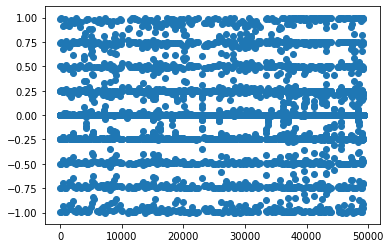

In [22]:
windows = [1, 2, 3, 6]
max_window = max(windows)

i_s = []
D_d_s = []

with open('lr.pickle', 'rb') as h:
    lr = pickle.load(h)
    
X = df_train.drop(columns=['label', 'pred']).to_numpy()

for i in df_train.index[max_window:-max_window]:
    d_s = [lr.predict_proba(np.concatenate((X[i-window, :], X[i, :])).reshape(1, -1))[0, 1] for window in windows]
    D_s = [lr.predict_proba(np.concatenate((X[i, :], X[i+window, :])).reshape(1, -1))[0, 1] for window in windows]
#     print(d_s)
    d = sum(d_s) / len(d_s)
    D = sum(D_s) / len(D_s)
    D_d = D-d
    
    i_s.append(i)
    D_d_s.append(D_d)
    
    
plt.scatter(x=i_s, y=D_d_s)

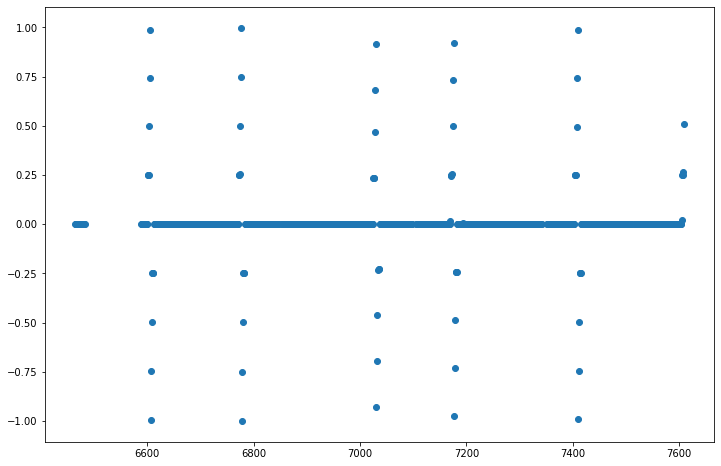

In [32]:
x0 = 4500
lim = 1000
plt.figure(figsize=(12, 8))
plt.scatter(x=df_train.loc[i_s[x0: x0+lim], 'frame_number'], y=D_d_s[:lim])

In [69]:
print((df_train.label == df_train.pred).sum() / len(df))
print(confusion_matrix(df_train.label, df_train.pred))
print(precision_score(df_train.label, df_train.pred))

0.9980562866977121
[[49144    88]
 [    8   150]]
0.6302521008403361


## Find threshold

In [20]:
with open('lr.pickle', 'rb') as h:
    lr = pickle.load(h)
    
max_window = max(windows)
    
for threshold in [1.47, 1.475, 1.48, 1.485, 1.49, 1.495, 1.5, 1.505]:
    df_train['pred'] = 0

    df_train.loc[0, 'pred'] = 1
    
    D_d_s = []

    X = df_train.drop(columns=['label', 'pred']).to_numpy()

    for i in df_train.index[max_window:-max_window]:
        d_s = [lr.predict_proba(np.concatenate((X[i-window, :], X[i, :])).reshape(1, -1))[0, 1] for window in windows]
        D_s = [lr.predict_proba(np.concatenate((X[i, :], X[i+window, :])).reshape(1, -1))[0, 1] for window in windows]
    #     print(d_s)
        d = sum(d_s) / len(d_s)
        D = sum(D_s) / len(D_s)
        D_d = D-d

        if D_d_s and (D_d_s[-1] - D_d > threshold):
            df_train.loc[i, 'pred'] = 1
            
        D_d_s.append(D_d)
            
    print(threshold)
    print('Accuracy:', (df_train.label == df_train.pred).sum() / len(df))
    print('Precision:', precision_score(df_train.label, df_train.pred))
    print('Recall:', recall_score(df_train.label, df_train.pred))
    print(df_train.pred.sum(), 'of', df_train.label.sum(), 'vehs')
    print(confusion_matrix(df_train.label, df_train.pred))
    print()

1.47
Accuracy: 0.999352095565904
Precision: 0.9256198347107438
Recall: 0.9411764705882353
242 of 238 vehs
[[49134    18]
 [   14   224]]

1.475
Accuracy: 0.9993723425794695
Precision: 0.9294605809128631
Recall: 0.9411764705882353
241 of 238 vehs
[[49135    17]
 [   14   224]]

1.48
Accuracy: 0.9993723425794695
Precision: 0.9294605809128631
Recall: 0.9411764705882353
241 of 238 vehs
[[49135    17]
 [   14   224]]

1.485
Accuracy: 0.999352095565904
Precision: 0.9291666666666667
Recall: 0.9369747899159664
240 of 238 vehs
[[49135    17]
 [   15   223]]

1.49
Accuracy: 0.9993723425794695
Precision: 0.9330543933054394
Recall: 0.9369747899159664
239 of 238 vehs
[[49136    16]
 [   15   223]]

1.495
Accuracy: 0.999392589593035
Precision: 0.9369747899159664
Recall: 0.9369747899159664
238 of 238 vehs
[[49137    15]
 [   15   223]]

1.5
Accuracy: 0.999392589593035
Precision: 0.9369747899159664
Recall: 0.9369747899159664
238 of 238 vehs
[[49137    15]
 [   15   223]]

1.505
Accuracy: 0.99939258959

In [89]:
df_train.pred.sum()

1

In [52]:
print(df_train.info())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49390 entries, 0 to 49389
Data columns (total 9 columns):
frame_number      49390 non-null int64
yolo_rect_area    49390 non-null int64
b_mean            49390 non-null float64
g_mean            49390 non-null float64
r_mean            49390 non-null float64
x_centroid        49390 non-null float64
y_centroid        49390 non-null float64
label             49390 non-null int64
pred              49390 non-null int64
dtypes: float64(5), int64(4)
memory usage: 3.4 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49390 entries, 0 to 49389
Data columns (total 11 columns):
frame_number       49390 non-null int64
vehicle_type       49390 non-null object
yolo_rect_area     49390 non-null int64
yolo_centroid      49390 non-null object
b_mean             49390 non-null float64
g_mean             49390 non-null float64
r_mean             49390 non-null float64
yolo_confidence    49390 non-null float64
Label              49390 non-null flo

In [56]:
current_car = 0
for i in df_train.index:
    if df_train.loc[i, 'pred'] == 1:
        current_car += 1
    df_train.loc[i, 'vehicle_number'] = current_car
    
df['vehicle_number'] = df_train.vehicle_number

In [57]:
df.head(100)

,frame_number,vehicle_type,yolo_rect_area,yolo_centroid,b_mean,g_mean,r_mean,yolo_confidence,Label,Numero carro,pred,vehicle_number
0,1,car,242606,"(673.5, 266.0)",86.896787,87.765991,102.278505,0.950672,1.0,1.0,1,1.0
1,2,car,239328,"(674.0, 266.0)",86.780690,87.449471,102.158180,0.948659,1.0,1.0,0,1.0
2,3,car,240929,"(673.5, 266.5)",86.756933,87.457608,102.179792,0.953693,1.0,1.0,0,1.0
3,4,car,241791,"(673.5, 266.5)",86.973043,87.615283,102.400023,0.951067,1.0,1.0,0,1.0
4,5,car,240108,"(673.5, 267.0)",86.765860,87.351346,102.312597,0.951930,1.0,1.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,261,car,171389,"(679.5, 276.5)",102.734365,100.714620,98.027236,0.982017,1.0,2.0,0,2.0
96,262,car,171756,"(680.0, 276.5)",102.650120,100.671907,97.998207,0.981742,1.0,2.0,0,2.0
97,263,car,171756,"(680.0, 276.5)",102.444124,100.418961,97.824012,0.984943,1.0,2.0,0,2.0
98,264,car,172960,"(680.0, 276.0)",102.386118,100.424121,97.823451,0.984609,1.0,2.0,0,2.0


In [59]:
df.to_csv('output/csvs/day_and_night_with_predictions.csv')

# 

# Try 12-features (no frame_number) Random Forest

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49390 entries, 0 to 49389
Data columns (total 8 columns):
frame_number      49390 non-null int64
yolo_rect_area    49390 non-null int64
b_mean            49390 non-null float64
g_mean            49390 non-null float64
r_mean            49390 non-null float64
x_centroid        49390 non-null float64
y_centroid        49390 non-null float64
label             49390 non-null int64
dtypes: float64(5), int64(3)
memory usage: 3.0 MB


49383


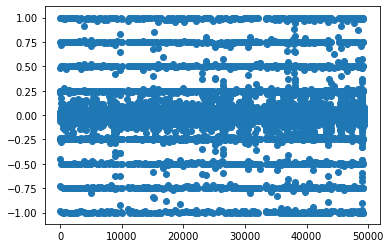

In [45]:
windows = [1, 2, 3, 6]
max_window = max(windows)
len_windows = len(windows)

i_s = []
D_d_s = []

with open('forest.pickle', 'rb') as h:
    forest = pickle.load(h)
    
X = make_training_dataset(df_train, windows=windows, drop=['pred', 'label', 'frame_number'], label=None).set_index('ID')
probas = forest.predict_proba(X)[:, 1]
X['probas'] = probas
# print(X.head())

for i in df_train.index[max_window:-max_window]: # range(max_window, df_train.shape[0]-max_window)
    d_s = [X.loc[str(i-window) + '_' + str(i), 'probas'] for window in windows]
    D_s = [X.loc[str(i) + '_' + str(i+window), 'probas'] for window in windows]

    d = sum(d_s) / len(d_s)
    D = sum(D_s) / len(D_s)
    D_d = D-d
    
    i_s.append(i)
    D_d_s.append(D_d)
    
print(i)
plt.scatter(x=i_s, y=D_d_s)

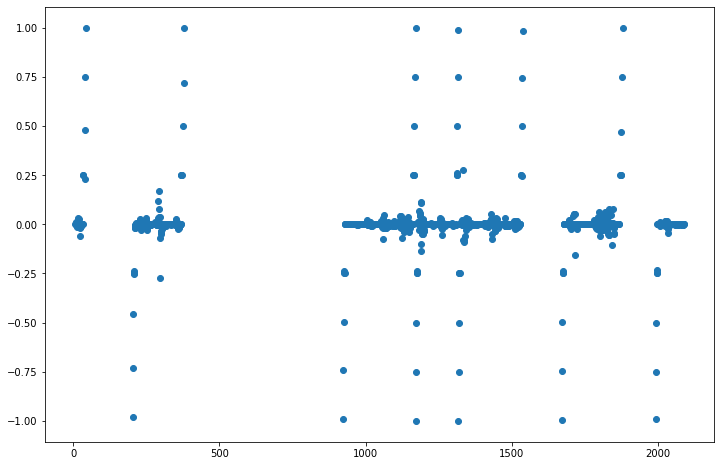

In [46]:
x0 = 0
lim = 1100
plt.figure(figsize=(12, 8))
plt.scatter(x=df_train.loc[i_s[x0: x0+lim], 'frame_number'], y=D_d_s[:lim])

## Find Threshold

In [41]:
g_threshold = [0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94]
g_windows = [[1, 2, 3, 6],
             [1, 3, 6],
             [1, 2, 4, 7],
             [1, 3, 5],
             [2, 3, 7, 12],
             [1, 2, 4, 8, 16, 32],
             [1, 2, 3, 5, 8, 13],
             [1, 3, 5, 10, 25],
             [3, 4, 5, 6]]

with open('forest.pickle', 'rb') as h:
    forest = pickle.load(h)
    
df_train['pred'] = 0
    
gs_results = pd.DataFrame(columns=['windows', 'threshold', 'accuracy', 'precision', 'recall', 'n_vehs'])
    
for windows in g_windows:
    max_window = max(windows)
    len_windows = len(windows)

    X = make_training_dataset(df_train, windows=windows, drop=['pred', 'label', 'frame_number'], label=None).set_index('ID')
    probas = forest.predict_proba(X)[:, 1]
    X['probas'] = probas

    for threshold in g_threshold:
        df_train['pred'] = 0

        df_train.loc[0, 'pred'] = 1

        for i in df_train.index[max_window:-max_window]:
            d_s = [X.loc[str(i-window) + '_' + str(i), 'probas'] for window in windows]
            D_s = [X.loc[str(i) + '_' + str(i+window), 'probas'] for window in windows]
        #     print(d_s)
            d = sum(d_s) / len(d_s)
            D = sum(D_s) / len(D_s)
            D_d = D-d

            if D_d_s and (D_d_s[-1] - D_d > threshold):
                df_train.loc[i, 'pred'] = 1
        
        accuracy = (df_train.label == df_train.pred).sum() / len(df)
        precision = precision_score(df_train.label, df_train.pred)
        recall = recall_score(df_train.label, df_train.pred)
        n_vehs = df_train.pred.sum()
        
        gs_results = gs_results.append({'windows':windows, 'threshold':threshold,
                                        'accuracy':accuracy, 'precision':precision,
                                        'recall':recall, 'n_vehs':n_vehs
                                       }, ignore_index=True)
        gs_results.to_csv('forest_gs_results.csv')
        
        print(windows, threshold)
        print('Accuracy:', accuracy)
        print('Precision:', precision)
        print('Recall:', recall)
        print(n_vehs, 'of', df_train.label.sum(), 'vehs')
        print(confusion_matrix(df_train.label, df_train.pred))
        print()

[1, 2, 3, 6] 0.64
Accuracy: 0.9953229398663697
Precision: 0.5076252723311547
Recall: 0.9789915966386554
459 of 238 vehs
[[48926   226]
 [    5   233]]

[1, 2, 3, 6] 0.66
Accuracy: 0.9953431868799352
Precision: 0.5087336244541485
Recall: 0.9789915966386554
458 of 238 vehs
[[48927   225]
 [    5   233]]

[1, 2, 3, 6] 0.68
Accuracy: 0.9953431868799352
Precision: 0.5087336244541485
Recall: 0.9789915966386554
458 of 238 vehs
[[48927   225]
 [    5   233]]

[1, 2, 3, 6] 0.7
Accuracy: 0.9953634338935007
Precision: 0.5098901098901099
Recall: 0.9747899159663865
455 of 238 vehs
[[48929   223]
 [    6   232]]

[1, 2, 3, 6] 0.72
Accuracy: 0.9955254100020247
Precision: 0.5190156599552572
Recall: 0.9747899159663865
447 of 238 vehs
[[48937   215]
 [    6   232]]

[1, 2, 3, 6] 0.74
Accuracy: 0.9964770196396031
Precision: 0.58
Recall: 0.9747899159663865
400 of 238 vehs
[[48984   168]
 [    6   232]]

[1, 2, 3, 6] 0.76
Accuracy: 0.999797529864345
Precision: 0.9956521739130435
Recall: 0.9621848739495799


In [47]:
gs_results['abs_error'] = (gs_results.n_vehs - 238).abs()
gs_results.sort_values(by='abs_error').head(25)

,windows,threshold,accuracy,precision,recall,n_vehs,abs_error
20,"[1, 3, 6]",0.72,0.999534,0.953586,0.949580,237,1
52,"[1, 3, 5]",0.72,0.999534,0.953586,0.949580,237,1
121,"[1, 3, 5, 10, 25]",0.82,0.999534,0.953586,0.949580,237,1
19,"[1, 3, 6]",0.70,0.999615,0.954357,0.966387,241,3
51,"[1, 3, 5]",0.70,0.999636,0.954545,0.970588,242,4
53,"[1, 3, 5]",0.74,0.999474,0.952991,0.936975,234,4
21,"[1, 3, 6]",0.74,0.999474,0.952991,0.936975,234,4
22,"[1, 3, 6]",0.76,0.999474,0.952991,0.936975,234,4
23,"[1, 3, 6]",0.78,0.999474,0.952991,0.936975,234,4
54,"[1, 3, 5]",0.76,0.999453,0.952790,0.932773,233,5


# Try on turns

In [25]:
X.tail()

,yolo_rect_area_1,b_mean_1,g_mean_1,r_mean_1,x_centroid_1,y_centroid_1,yolo_rect_area_2,b_mean_2,g_mean_2,r_mean_2,x_centroid_2,y_centroid_2,probas
ID,,,,,,,,,,,,,
49382_49388,466631.0,154.441063709869,114.50946036589899,104.592605291976,549.5,381.5,448350.0,49.5976848444296,45.5925080852013,50.6058681833389,372.5,415.0,0.0
49383_49384,581670.0,139.712330015301,105.54373785823601,100.090568535424,489.5,375.0,610572.0,125.17500966306999,94.4852777395623,91.56096905852208,489.0,371.5,0.0
49383_49385,581670.0,139.712330015301,105.54373785823601,100.090568535424,489.5,375.0,527744.0,106.92478360720301,75.6676854687121,70.9327666444337,448.0,374.0,0.0
49383_49386,581670.0,139.712330015301,105.54373785823601,100.090568535424,489.5,375.0,547404.0,96.2225084215679,67.20230944603989,63.9445400472046,442.0,373.0,0.0
49383_49389,581670.0,139.712330015301,105.54373785823601,100.090568535424,489.5,375.0,377300.0,40.3833236151603,47.6376941425921,47.9404108136761,351.0,442.5,0.0


In [27]:
df_train.tail()

,frame_number,yolo_rect_area,b_mean,g_mean,r_mean,x_centroid,y_centroid,label
49385,110825,527744,106.924784,75.667685,70.932767,448.0,374.0,0
49386,110826,547404,96.222508,67.202309,63.944540,442.0,373.0,0
49387,110828,483786,73.937067,59.803874,63.981963,425.5,368.0,0
49388,110829,448350,49.597685,45.592508,50.605868,372.5,415.0,0
49389,110832,377300,40.383324,47.637694,47.940411,351.0,442.5,0
